# Vipir Ground Truth

This notebook compares objects detected in the test images with their ground truths.

In [1]:
import sys
sys.path.append('/home/kevin_leo_mcmanus/vipir/TensorFlow/models/research')

In [2]:
import os
import pathlib

In [3]:
from vipir.vipir import vipir as vp

In [4]:
import numpy as np
import pandas as pd
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [5]:
from object_detection.utils import ops as utils_ops
#from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [6]:
from vipir.utils import modelutils as mod_util

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

```
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model
```

```
PATH_TO_LABELS = './resnet_train/data/vipir_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
```

In [8]:
model_name = 'vipir_resnet'
PATH_TO_LABELS = './resnet_train/data/vipir_label_map.pbtxt'
detection_model = mod_util.load_model(model_name, PATH_TO_LABELS)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
detection_model['labels']

{1: {'id': 1, 'name': 'interference'}, 2: {'id': 2, 'name': 'trace'}}

## Bounding Boxes
Bounding boxes originate in the upper left corner and the height dimension increases toward the lower left corner (downward). The width dimension increases to the right of the imaage. The coordinates come back from the object detector in a four element vector {ymin, xmin, ymax, xmax}. Note that the min and max pairs are reversed from the usual sense: normally we think of (x,y) coordinates for points on a graph; in this case, we're getting (height, width) coordinates which correspond to (y,x). Furthermore, the detector returns __normalized__ coordinates which are percentages of the axis.

## Rectangles
Rectangles are regions on a graph. They are described by an origin, an extent in the x direction and an extent in the y direction.

In [10]:
wi937=vp('./netcdf/WI937_2019327130203.NGI')

In [11]:
objs = wi937.get_objects(detection_model)

In [12]:
objs

[{'score': 0.753716,
  'objtype': 2,
  'label': 'trace',
  'bbox_norm': array([0.713236  , 0.15639561, 0.8394674 , 0.5397159 ], dtype=float32),
  'rngfreq': {'coords': {'minfreq': 1896.093,
    'maxfreq': 5861.27,
    'minrng': 226.33916,
    'maxrng': 407.7136},
   'indices': {'minfreq_i': 51,
    'maxfreq_i': 177,
    'minrng_i': 154,
    'maxrng_i': 275}}}]

In [13]:
objs[0]['rngfreq']['indices']


{'minfreq_i': 51, 'maxfreq_i': 177, 'minrng_i': 154, 'maxrng_i': 275}

## Matplotlib Stuff

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

In [15]:
%matplotlib inline

In [16]:
def draw_box_on_axis(ax, l_left, xext, yext,
                    label=None, color='red', linestyle='-',linewidth=3):

    r = patches.Rectangle( l_left, xext, yext,facecolor='none',
                      edgecolor= color, linestyle=linestyle, linewidth=linewidth, label=label)

    ax.add_patch(r)   

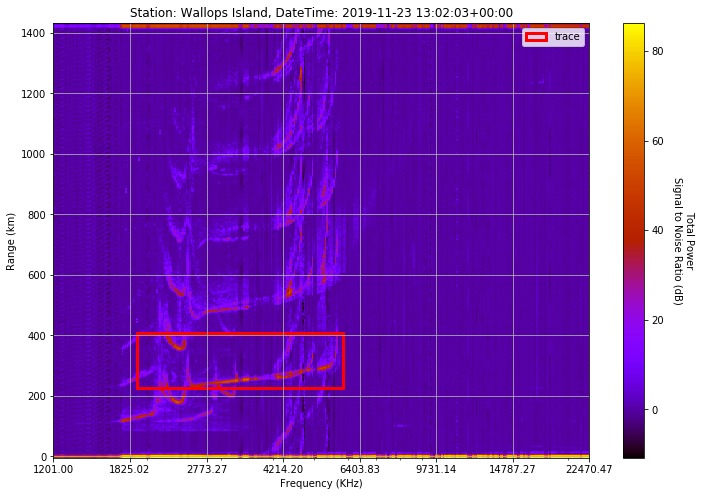

In [17]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    return "%.2f" % x

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
pcm = ax.pcolormesh(wi937.freq, wi937.rng, wi937.snr().T, cmap='gnuplot')

rngfreq = objs[0]['rngfreq']['coords']
draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                      rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                      rngfreq['maxrng'] - rngfreq['minrng'],  #y-extent
                      label=objs[0]['label'])

ax.set_title(f'Station: {wi937.station}, DateTime: {wi937.obs_time}')
ax.set_ylabel('Range (km)')
ax.set_xlabel('Frequency (KHz)')

ax.set_xscale('log')
ax.grid()
ax.legend(loc='upper right')

ax.set_xticks(np.logspace(np.log10(wi937.minfreq), np.log10(wi937.maxfreq),8))
ax.xaxis.set_major_formatter(major_formatter)

cbar=fig.colorbar(pcm, ax=ax)
cbar.set_label('Total Power\nSignal to Noise Ratio (dB)', rotation=270, labelpad=30)

In [18]:
PATH_TO_TEST_FILE_LIST = './resnet_train/data/annotations/test.txt'
with open(PATH_TO_TEST_FILE_LIST,'r') as fid:
    test_file_list = fid.readlines()
test_file_list = [t.split()[0] for t in test_file_list]

In [19]:
test_file_list[0:3]

['WI937_2020013112402', 'WI937_2019308022503', 'SJJ18_2019316023002']

In [20]:
from vipir.utils import annotationtodict as ad

In [21]:
ad.annotationtodict(test_file_list[0],'resnet_train')

{'folder': 'images',
 'basename': 'WI937_2020013112402',
 'name': 'trace',
 'bndbox': array([0.74511719, 0.125     , 0.86328125, 0.44433594])}

In [22]:
bbox=ad.annotationtodict('WI937_2019327130203','resnet_train')['bndbox']

In [23]:
bbox

array([0.74902344, 0.19921875, 0.875     , 0.54492188])

In [24]:
wi937.bbox_rngfreq(bbox)

{'coords': {'minfreq': 2149.359,
  'maxfreq': 5914.012,
  'minrng': 175.37444,
  'maxrng': 355.2499},
 'indices': {'minfreq_i': 65,
  'maxfreq_i': 178,
  'minrng_i': 120,
  'maxrng_i': 240}}

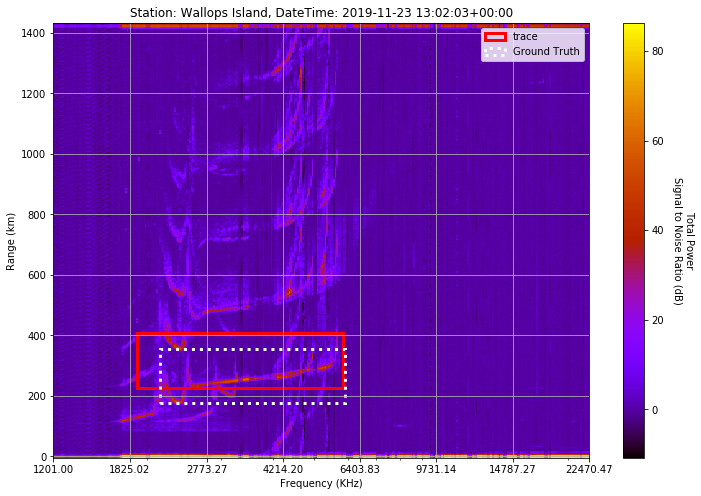

In [25]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    return "%.2f" % x

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
pcm = ax.pcolormesh(wi937.freq, wi937.rng, wi937.snr().T, cmap='gnuplot')

for i in range(len(objs)):
    rngfreq = objs[i]['rngfreq']['coords']
    draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                          rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                          rngfreq['maxrng'] - rngfreq['minrng'], #y-extent
                          label=objs[i]['label']
                    )

#put on the ground truth
rngfreq = wi937.bbox_rngfreq( bbox)['coords']
draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                      rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                      rngfreq['maxrng'] - rngfreq['minrng'],   #y-extent
                      color = 'white', linestyle=':', label='Ground Truth')

ax.set_title(f'Station: {wi937.station}, DateTime: {wi937.obs_time}')
ax.set_ylabel('Range (km)')
ax.set_xlabel('Frequency (KHz)')

ax.set_xscale('log')
ax.grid()
ax.legend(loc='upper right')

ax.set_xticks(np.logspace(np.log10(wi937.minfreq), np.log10(wi937.maxfreq),8))
ax.xaxis.set_major_formatter(major_formatter)

cbar=fig.colorbar(pcm, ax=ax)
cbar.set_label('Total Power\nSignal to Noise Ratio (dB)', rotation=270, labelpad=30)

In [26]:
vip = vp(os.path.join('netcdf',test_file_list[0]+'.NGI'))
ann = ad.annotationtodict(test_file_list[0],'resnet_train')

In [27]:
ann

{'folder': 'images',
 'basename': 'WI937_2020013112402',
 'name': 'trace',
 'bndbox': array([0.74511719, 0.125     , 0.86328125, 0.44433594])}

In [28]:
objs = vip.get_objects(detection_model)

In [29]:
objs

[{'score': 0.9055261,
  'objtype': 2,
  'label': 'trace',
  'bbox_norm': array([0.75136006, 0.05829473, 0.8633138 , 0.48111176], dtype=float32),
  'rngfreq': {'coords': {'minfreq': 1423.7,
    'maxfreq': 4899.852,
    'minrng': 191.86302,
    'maxrng': 352.25198},
   'indices': {'minfreq_i': 19,
    'maxfreq_i': 157,
    'minrng_i': 131,
    'maxrng_i': 238}}}]

In [30]:
for i in objs:
    print (f'index: {i}')

index: {'score': 0.9055261, 'objtype': 2, 'label': 'trace', 'bbox_norm': array([0.75136006, 0.05829473, 0.8633138 , 0.48111176], dtype=float32), 'rngfreq': {'coords': {'minfreq': 1423.7, 'maxfreq': 4899.852, 'minrng': 191.86302, 'maxrng': 352.25198}, 'indices': {'minfreq_i': 19, 'maxfreq_i': 157, 'minrng_i': 131, 'maxrng_i': 238}}}


In [31]:

def show_objects(vip, objs, which='total_power', ann=None, ax=None, iou=None, colorbar=True, crop=True):
    @ticker.FuncFormatter
    def major_formatter_f(x, pos):
        return "%.2f" % (x/1000.0)
    
    @ticker.FuncFormatter
    def major_formatter_r(x, pos):
        return "%.2f" % x
    
    pcm = ax.pcolormesh(vip.freq, vip.rng, vip.snr(which=which).T, vmin=0, vmax=60, cmap='gnuplot')
    if len(objs) >0:
        for o in objs:
            rngfreq = o['rngfreq']['coords']
            label_str = 'Detected Class: '+ o['label']
            draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                                  rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                                  rngfreq['maxrng'] - rngfreq['minrng'], #y-extent
                                  label=label_str)
            
    #put on the ground truth
    if ann is not None:
        true_bbox = ann['bndbox']
        label_str = 'Ground Truth: '+ann['name']
        rngfreq = vip.bbox_rngfreq(true_bbox)['coords']
        draw_box_on_axis(ax, (rngfreq['minfreq'], rngfreq['minrng']), #origin
                              rngfreq['maxfreq'] - rngfreq['minfreq'], #x-extent
                              rngfreq['maxrng'] - rngfreq['minrng'],   #y-extent
                              linestyle=':', color = 'white', label=label_str)
    
    if iou is not None:
        textstr = r'$\mathrm{iou}=%.4f$' % iou
        props = dict(boxstyle='round', facecolor='lightgrey') #, alpha=0.5
        ax.text(0.80, 0.80, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    ax.set_title(f'Station: {vip.station}\nDateTime: {vip.obs_time}',
                fontdict={'size':16, 'weight':'bold'})
    ax.set_ylabel('Range (km)')
    ax.set_xlabel('Frequency (MHz)')

    ax.set_xscale('log')
 
    if crop:
        ax.set_yscale('log')
        ax.set_ylim(50,None)
        
    ax.grid()
    ax.legend(loc='upper right', fontsize=14)

    ax.set_xticks(np.logspace(np.log10(vip.minfreq), np.log10(vip.maxfreq),8))
    ax.xaxis.set_major_formatter(major_formatter_f)
    
    if crop:
        ax.set_yticks(np.logspace(np.log10(50), np.log10(1000),8))
    #ax.set_yticks(np.log10(np.array([50,70,100,140,200,300,500,900])))
    ax.yaxis.set_major_formatter(major_formatter_r)

    if colorbar:
        cbar=fig.colorbar(pcm, ax=ax)
        cbar.set_label('Total Power\nSignal to Noise Ratio (dB)', rotation=270, labelpad=30)

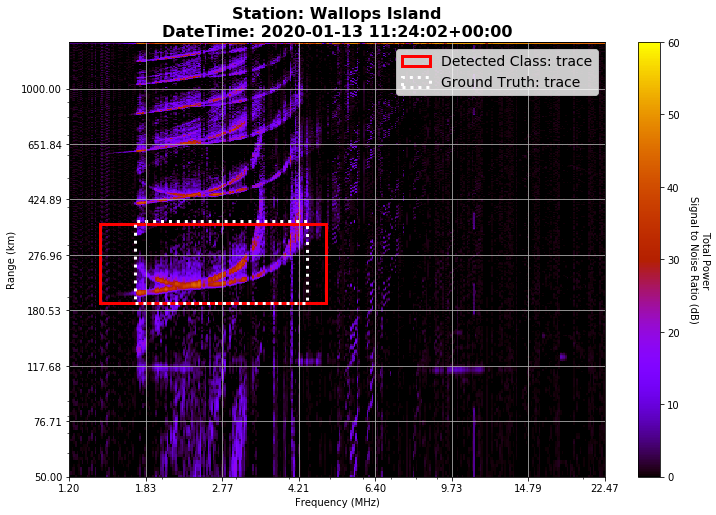

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

show_objects(vip, objs, ann=ann, ax=ax)

In [33]:
len(test_file_list)

48

## Intersect over Union

In [34]:
ann

{'folder': 'images',
 'basename': 'WI937_2020013112402',
 'name': 'trace',
 'bndbox': array([0.74511719, 0.125     , 0.86328125, 0.44433594])}

In [35]:
objs[0]['bbox_norm']

array([0.75136006, 0.05829473, 0.8633138 , 0.48111176], dtype=float32)

In [36]:
def area(box):
    """
    computes the area covered by the box.
    box is of the form ymin, xmin, ymax, xmax (normalized, and origin upper left)
    """
    h = box[2] - box[0]
    w = box[3] - box[1]
    a = h*w
    
    return a

In [37]:
area(objs[0]['bbox_norm'])

0.04733595

In [38]:
def box_intersect(box1, box2):
    """
    computes intersection of two boxes.
    boxes are of the form ymin, xmin, ymax, xmax (normalized, and origin upper left)
    returns None if the boxes don't intersect
    """
    
    y1min, x1min, y1max, x1max = box1
    y2min, x2min, y2max, x2max = box2
    
    xmin = max(x1min, x2min)
    xmax = min(x1max, x2max)
    ymin = max(y1min, y2min)
    ymax = min(y1max, y2max)
    
    if xmin > xmax or ymin > ymax: #no intersection
        return None
    else:
        return np.array([ymin, xmin, ymax, xmax])
    

In [39]:
 objs[0]['bbox_norm']

array([0.75136006, 0.05829473, 0.8633138 , 0.48111176], dtype=float32)

In [40]:
ann['bndbox']

array([0.74511719, 0.125     , 0.86328125, 0.44433594])

In [41]:
box_intersect(objs[0]['bbox_norm'], ann['bndbox'])

array([0.75136006, 0.125     , 0.86328125, 0.44433594])

In [42]:
def intersect_over_union(box1, box2):
    """
    computes the area of intersection divided by the area of union of the two argument boxes
    boxes are of the form ymin, xmin, ymax, xmax (normalized, and origin upper left)    
    """
    
    # get the intersection
    boxi = box_intersect(box1, box2)
    if boxi is not None:
        #the boxes have an intersection
        a1 = area(box1)
        a2 = area(box2)
        ai = area(boxi)
        iou = ai/(a1+a2-ai)
    else:
        iou = 0.0
    
    return iou

In [43]:
iou = intersect_over_union(objs[0]['bbox_norm'], ann['bndbox'])

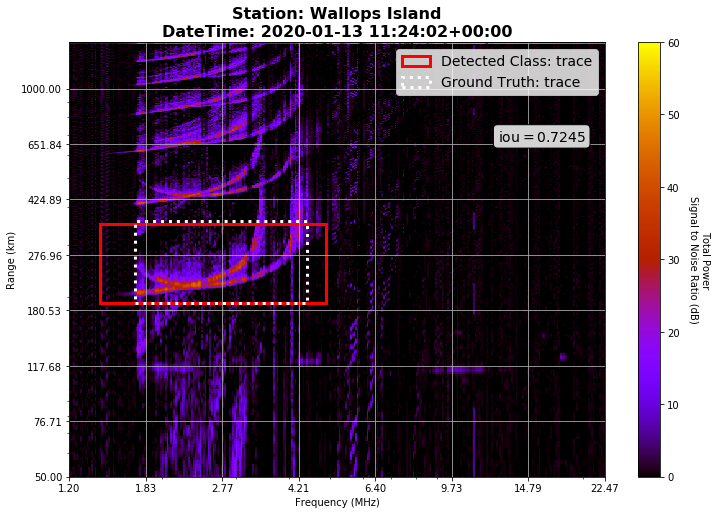

In [44]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

show_objects(vip, objs, ann=ann, ax=ax, iou=iou)

In [45]:
wi937.bbox_rngfreq(bbox)

{'coords': {'minfreq': 2149.359,
  'maxfreq': 5914.012,
  'minrng': 175.37444,
  'maxrng': 355.2499},
 'indices': {'minfreq_i': 65,
  'maxfreq_i': 178,
  'minrng_i': 120,
  'maxrng_i': 240}}

In [46]:
len(test_file_list)

48

In [47]:
test_file_list[1]

'WI937_2019308022503'

In [48]:
ad.annotationtodict(test_file_list[0],'resnet_train')

{'folder': 'images',
 'basename': 'WI937_2020013112402',
 'name': 'trace',
 'bndbox': array([0.74511719, 0.125     , 0.86328125, 0.44433594])}

In [49]:
import time
def score(f, detection_model):
    #get the annotations
    ann = ad.annotationtodict(f,'resnet_train')
    
    #time the object detection

    vip = vp(os.path.join('netcdf',f + '.NGI'))

    
    try:
        start_time = time.time()
        objs = vip.get_objects(detection_model)
        elapsed_time=time.time() - start_time

        #compute the iou
        if len(objs) > 0:
            iou = intersect_over_union(objs[0]['bbox_norm'], ann['bndbox'])
            label = objs[0]['label']
        else:
            iou = 0.0
            label = '<none>'
    except:
        iou = np.nan
        label = '<none>'
        elapsed_time = np.nan

    return {'Filename': f, 'GroundTruthClass': ann['name'], 'DetectedClass': label, 'IOU': iou,'ElapsedTime':elapsed_time}

In [50]:
score(test_file_list[3], detection_model)

{'Filename': 'WI937_2019320085803',
 'GroundTruthClass': 'trace',
 'DetectedClass': '<none>',
 'IOU': nan,
 'ElapsedTime': nan}

In [51]:
#iou_scores = pd.DataFrame([score(f,detection_model) for f in test_file_list])

#iou_scores.to_csv('iou_scores.csv')

In [52]:
iou_scores=pd.read_csv('iou_scores.csv')

In [53]:
iou_scores

,Unnamed: 0,Filename,GroundTruthClass,DetectedClass,IOU,ElapsedTime
0,0,WI937_2020013112402,trace,trace,0.724525,17.775667
1,1,WI937_2019308022503,interference,<none>,0.000000,17.663511
2,2,SJJ18_2019316023002,trace,trace,0.851898,17.684147
3,3,WI937_2019320085803,trace,trace,0.589256,17.393203
4,4,SJJ18_2019075074802,trace,trace,0.805546,17.657891
5,5,SJJ18_2019337233801,trace,trace,0.675052,17.118537
6,6,WI937_2019327130203,trace,trace,0.503681,17.039760
7,7,SJJ18_2019297154602,trace,trace,0.671524,17.810428
8,8,JV433_2019362193000,trace,<none>,0.000000,17.268636
9,9,WI937_2020016101802,trace,trace,0.794549,17.183792


In [54]:
from sklearn.metrics import confusion_matrix

In [55]:
cm_df = pd.DataFrame(confusion_matrix(iou_scores.GroundTruthClass, iou_scores.DetectedClass),
                     index = pd.Index(['<none>','interference','trace'],name='GroundTruth'),
                     columns = pd.Index(['<none>','interference','trace'],name='DetectedClass') )

In [56]:
cm_df

DetectedClass,<none>,interference,trace
GroundTruth,,,
<none>,0,0,0
interference,6,6,2
trace,8,0,26


In [57]:
iou_scores.GroundTruthClass.value_counts()

trace           34
interference    14
Name: GroundTruthClass, dtype: int64

In [58]:
import seaborn as sn


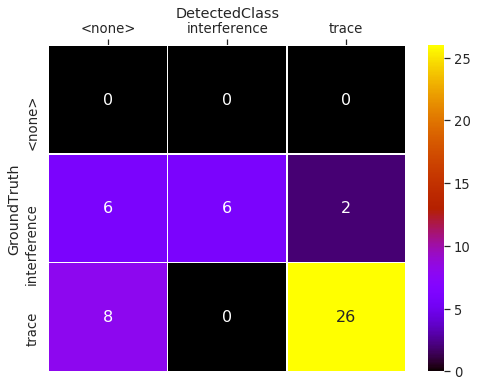

In [59]:
fig = plt.figure(figsize=(8,6))
sn.set(font_scale=1.2) # for label size
ax = sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}, cmap='gnuplot',
          linewidths=0.5) # font size
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

In [60]:
iou_scores.query('GroundTruthClass==\'trace\' and DetectedClass==\'<none>\'')

,Unnamed: 0,Filename,GroundTruthClass,DetectedClass,IOU,ElapsedTime
8,8,JV433_2019362193000,trace,<none>,0.0,17.268636
16,16,SJJ18_2019341165602,trace,<none>,0.0,17.401536
20,20,WI937_2019004221403,trace,<none>,0.0,17.655373
21,21,JV433_2019302171500,trace,<none>,0.0,17.503474
24,24,SJJ18_2019207182201,trace,<none>,0.0,17.315179
39,39,SJJ18_2020021002202,trace,<none>,0.0,17.400868
44,44,SJJ18_2019209193801,trace,<none>,0.0,17.359512
47,47,WI937_2020012031203,trace,<none>,0.0,17.765936


In [61]:
def show_gt(fname, ax):
    vip = vp(os.path.join('netcdf',fname +'.NGI'))
    ann = ad.annotationtodict(fname,'resnet_train')
    try:
        objs=vip.get_objects(detection_model)
        if len(objs) > 0:
            iou = intersect_over_union(objs[0]['bbox_norm'], ann['bndbox'])
            label = objs[0]['label']
        else:
            iou = 0.0
            label = '<none>'
    except:
        objs = []
        iou = np.nan
        label = '<none>'
    # only crop in the case where ground truth was 'trace'
    show_objects(vip, objs, ann=ann, iou=iou, ax=ax, crop=ann['name']=='trace')
    
    return label == ann['name']

In [62]:
for f in test_file_list:
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()

    res=show_gt(f,ax)
    dir = 'correctly-classified' if res else 'mis-classified'
    path = os.path.join(dir, f+'.png')
    plt.savefig(path)
    plt.close()


In [63]:
print (res)

False


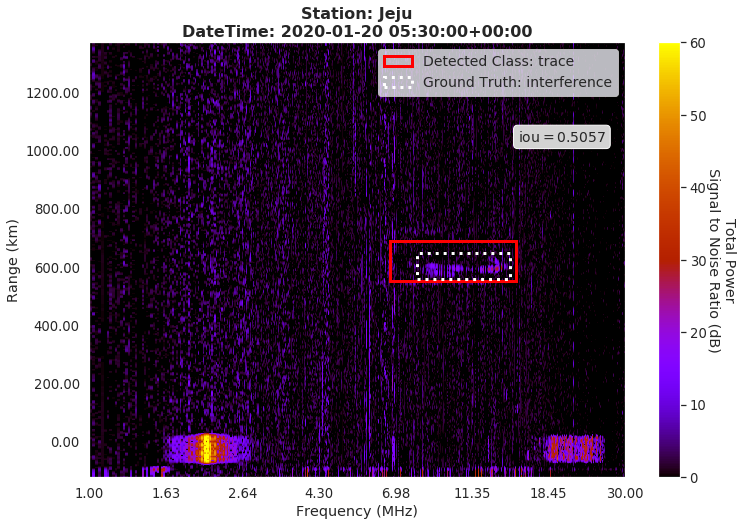

In [64]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
res=show_gt('JV433_2020020053000',ax)

In [65]:
len(test_file_list)

48

In [66]:
iou_scores.query('DetectedClass == \'trace\' and GroundTruthClass == \'trace\'').IOU.mean()

0.667755056157807